In [4]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
import matplotlib.pyplot as plt

sys.path.insert(0, '../../../icenumerics/')
sys.path.insert(0, '../auxnumerics/')
sys.path.insert(0, '..')
import icenumerics as ice

import auxiliary as aux
import montecarlo_tools as mc
import chirality_tools as chir
from parameters import params
ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [5]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [31]:
DRIVE_MOUNT = '/media/frieren/BIG/'
PROJECT = 'stuckgs/data'

In [32]:
datasmol = os.path.join(DRIVE_MOUNT,PROJECT,'sims/10')
databig = os.path.join(DRIVE_MOUNT,PROJECT,'sims/30')

# Vertices average expanded types

In [8]:
def get_vertices_from_realization(data_path,r=1):
    # importing vertices
    vrt_path = os.path.join(data_path,'vertices')
    vertices = pd.read_csv(os.path.join(vrt_path,f'vertices{r}.csv'))
    vertices[['dx','dy']] = np.around(vertices[['dx','dy']])
    
    # classify the vertices
    vertices = aux.classify_vrt_expanded(vertices)
    return ice.count_vertices(vertices)

In [122]:
# getting a dictionary with the vertices counts
counts_dict = {i:get_vertices_from_realization(databig,r=i) for i in range(1,10+1)}

# this is simply concatenating the columns in a single dataframe so that i can average columsn
complete_fractions = pd.concat([counts_dict[i].fraction for i in range(1,10+1)],axis=1)
vertices_average = complete_fractions.mean(axis=1)

In [123]:
pd.DataFrame(vertices_average,columns=['fraction']).to_csv(os.path.join(databig,'recount_expanded.csv'))

In [136]:
vrt_av = pd.DataFrame(vertices_average,columns=['fraction'])
vrt_av.xs('I',level='type')

,fraction
frame,
0,0.062291
10,0.063626
20,0.062180
30,0.063849
40,0.061624
...,...
8350,0.178643
8360,0.178643
8370,0.179088


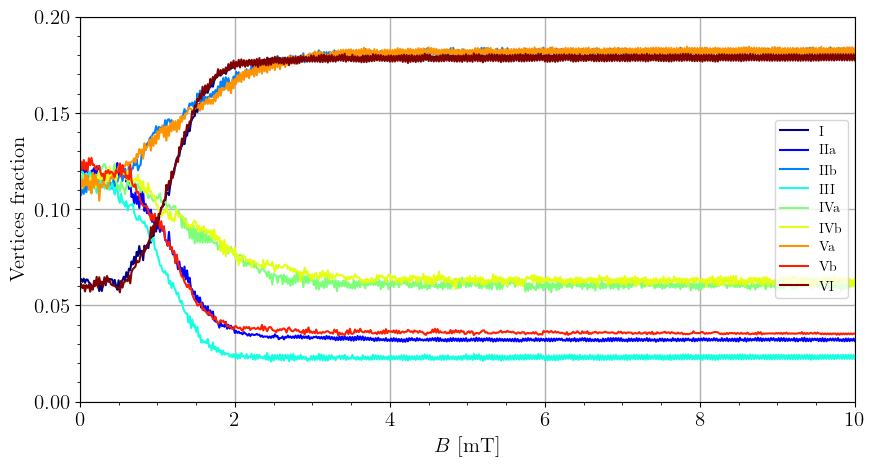

In [137]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = plt.get_cmap('jet')
colors = [cmap(i /8) for i in range(9) ]

types = ['I', 'IIa', 'IIb', 'III', 'IVa', 'IVb', 'Va', 'Vb', 'VI'] 
mapping = {tp:c for c,tp in zip(colors,types)}

for tp in types:
    
    ts = vrt_av.xs(tp,level='type').fraction
    field = ts.index.get_level_values('frame').unique().to_numpy()/20 * 10/300
    ax.plot(field,ts.to_numpy(),label=tp, c=mapping[tp])

ax.set_xlim(0,10)
ax.set_xlabel('$B$ [mT]',fontsize=15)

ax.set_ylim(0,0.2)
ax.set_ylabel('Vertices fraction', fontsize=15)

ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.xaxis.set_minor_formatter(plt.NullFormatter())


ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_minor_formatter(plt.NullFormatter())


ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(True, which='major', linewidth = 1)
ax.minorticks_on()

#plt.legend(types)
plt.legend()
plt.show()

# Usual vertices average

In [9]:
def averaged_vrt_counts(datapath):
    vrt_path = os.path.join(datapath,"vertices/")
    vertices = itrj.vrt_dict(vrt_path)
    counts = itrj.vrt_counts(vertices)
    
    # take all the fractions
    # concat in columsn of df, it will have indices automatically
    # take average by columns
    # reset index and get all frames before some value
    # reindex
    mean_counts = pd.concat(
        [stuff.fraction for stuff in counts.values()],axis=1
        ).dropna().mean(axis=1).reset_index().query('frame<=6000').set_index(['frame','type'])
    return mean_counts

In [19]:
smolmean = ice.unstack(ice.vrt_averages(os.path.join(datasmol,'vertices')))
bigmean = ice.unstack(ice.vrt_averages(os.path.join(databig,'vertices')))

In [21]:
bigmean.to_csv(os.path.join(databig,'counts.csv'))
smolmean.to_csv(os.path.join(datasmol,'counts.csv'))

In [20]:
bigmean

,I,II,III,IV,V,VI
frame,,,,,,
0,0.066587,0.247206,0.126873,0.243757,0.252913,0.062663
20,0.066468,0.246849,0.127586,0.244233,0.251843,0.063020
40,0.065874,0.247087,0.125684,0.245422,0.254816,0.061118
60,0.067658,0.245422,0.125446,0.244946,0.253389,0.063139
80,0.065517,0.244114,0.127705,0.248157,0.253508,0.060999
...,...,...,...,...,...,...
5920,0.192152,0.227348,0.023662,0.133532,0.233888,0.189417
5940,0.192033,0.227467,0.023662,0.133413,0.234007,0.189417
5960,0.192033,0.227111,0.023662,0.133769,0.234007,0.189417


## Importing and plotting 

In [26]:
dS = pd.read_csv(os.path.join(datasmol,'counts.csv'), index_col=['frame'])
dB = pd.read_csv(os.path.join(databig,'counts.csv'), index_col=['frame'])

In [27]:
time = cbig.index.get_level_values('frame').unique().to_numpy()/20
field = 10/300*time

In [28]:
cmap = plt.get_cmap('plasma')
colors = [cmap(i /3) for i in range(4) ]

gsmall = [
    dS['I'] + dS['VI'],
    dS['II'] + dS['V'],
    dS['IV'],
    dS['III']
]

gbig = [
    dB['I'] + dB['VI'],
    dB['II'] + dB['V'],
    dB['IV'],
    dB['III']
]

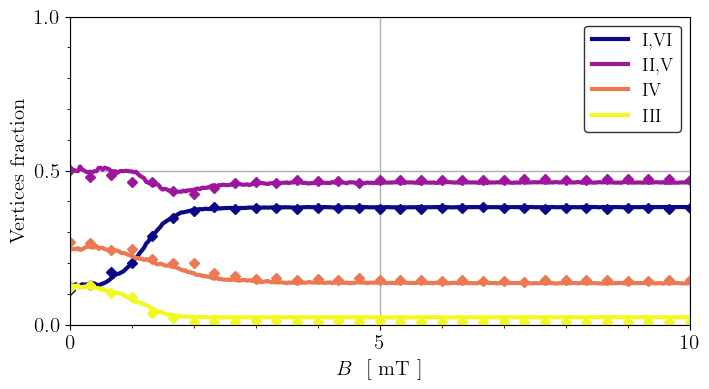

In [29]:
fig, ax = plt.subplots(figsize=(8,4))

types = ['I,VI','II,V','IV','III']

for i in range(4):
        ax.plot(field, gbig[i], color = colors[i], linewidth=3, label = types[i])
        ax.plot(field[::10], gsmall[i][::10], 'D', color = colors[i], markersize=5)

ax.legend(fontsize=13,edgecolor='black')

ax.set_xlim(0,10)
ax.set_ylim(0,1)

ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.xaxis.set_minor_formatter(plt.NullFormatter())


ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_minor_formatter(plt.NullFormatter())


ax.set_ylabel('Vertices fraction', fontsize=15)
ax.set_xlabel("$B$ \\,\\,[ mT ] ", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(True, which='major', linewidth = 1)
ax.minorticks_on()

plt.show()

#fig.savefig('../data/figs/fig2.pdf', bbox_inches='tight')
#fig.savefig('../data/figs/fig2.png', dpi=300, bbox_inches='tight')

# Vertices counts for staircase simulations

In [8]:
# first some important stuff
datapath = '/media/frieren/BIG/stuckgs/data/simstair_detailed'
intervals = [
    (30,330), 
    (333,633),
    (636,936),
    (939,1239),
    (1242,1542),
    (1545,1845),
    (1848,2148),
    (2151,2451),
    (2454,2754),
    (2757,3057),
    (3060,3360),
    (3390,3690),
    (3720,4020),
    (4050,4350),
    (4380,4680),
    (4710,5010),
    (5040,5340),
    (5370,5670),
    (5700,6000),
]
fields = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 3, 4, 5, 6, 7, 8, 9, 10]
params['framespersec'] = 1*ureg.Hz

In [193]:
pd.read_csv(os.path.join(datapath,'30','ctrj','xtrj1.csv'))
# just to check that each frame is one second

,frame,id,x,y,z,dx,dy,dz,t,cx,cy,cz
0,0,0,4.18701,0.000,0.0,3.000000e+00,0.0,0.0,0.0,1.500000,0.000000,0.0
1,0,1,12.56100,0.000,0.0,-3.000000e+00,-0.0,-0.0,0.0,-1.500000,0.000000,0.0
2,0,2,20.93500,0.000,0.0,3.000000e+00,0.0,0.0,0.0,1.500000,0.000000,0.0
3,0,3,29.30900,0.000,0.0,-3.000000e+00,-0.0,-0.0,0.0,-1.500000,0.000000,0.0
4,0,4,37.68310,0.000,0.0,-3.000000e+00,-0.0,-0.0,0.0,-1.500000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10799995,5999,1795,209.35000,247.033,0.0,1.836970e-16,3.0,0.0,5999.0,-0.008011,1.544998,0.0
10799996,5999,1796,217.72400,247.033,0.0,-1.836970e-16,-3.0,-0.0,5999.0,0.001007,-1.534012,0.0
10799997,5999,1797,226.09800,247.033,0.0,1.836970e-16,3.0,0.0,5999.0,-0.015015,1.537994,0.0
10799998,5999,1798,234.47200,247.033,0.0,-1.836970e-16,-3.0,-0.0,5999.0,-0.003006,-1.548004,0.0


In [189]:
def do_vertices_shit(data_path):
    vrt_path = os.path.join(data_path,"vertices/")
    vertices = aux.vrt_dict(vrt_path)
    return vertices
    counts = aux.vrt_counts(vertices)
    vrt_ts = aux.getVerticesAverage(counts,params["framespersec"])
    types = vrt_ts.columns.to_list()[1:]
    t = vrt_ts["time"].to_numpy()
    vrt_counts = vrt_ts[types].to_numpy()
    return t, vrt_counts

In [190]:
vrt_path = os.path.join(datapath,'30','vertices')
vrt_dict = aux.vrt_dict(vrt_path)
counts = aux.vrt_counts(vrt_dict)
mean_counts = pd.concat([stuff.fraction for stuff in counts.values()])
mean_counts.index = mean_counts.index.set_levels(
    mean_counts.index.levels[1].map(mapping),
    level=1
)

In [191]:
vrt_dict['1']

x      y  coordination  charge            dx   dy  type
frame vertex                                                             
0     0       242.0  242.0             4       0  0.000000e+00  0.0   3.0
      1       242.0  234.0             4       0  2.000000e+00  2.0   4.0
      6         8.0  159.0             4      -2 -2.000000e+00  0.0   2.0
      7        33.0  159.0             4      -2  2.000000e+00  0.0   2.0
      9        92.0   50.0             4      -2 -1.224647e-16 -2.0   2.0
...             ...    ...           ...     ...           ...  ...   ...
5999  894     226.0  234.0             4       4  0.000000e+00  0.0   6.0
      895     209.0  234.0             4       4  0.000000e+00  0.0   6.0
      896     209.0  200.0             4       4  0.000000e+00  0.0   6.0
      897     184.0  226.0             4       4  0.000000e+00  0.0   6.0
      898     209.0  133.0             4      -4  0.000000e+00  0.0   1.0

[5046000 rows x 7 columns]

In [196]:
mean_counts = pd.read_csv(os.path.join(datapath,'counts.csv'),index_col=['frame','type'])
frames = mean_counts.index.get_level_values('frame').unique().to_numpy()

global_counts = []
for c_interval in intervals:
    c_interval * params['framespersec'].magnitude

    counts = mean_counts.reset_index().query(
        f'frame >= {c_interval[0]+50} & frame <= {c_interval[1]-50}'
        ).groupby('type').mean().fraction
    
    global_counts.append(counts)


In [197]:
counts = pd.DataFrame(pd.concat(global_counts,axis=1).to_numpy().transpose(),columns = ['I','II','III','IV','V','VI'])

In [199]:
counts = pd.DataFrame(data = np.array(global_counts), columns = ['I','II','III','IV','V','VI'])


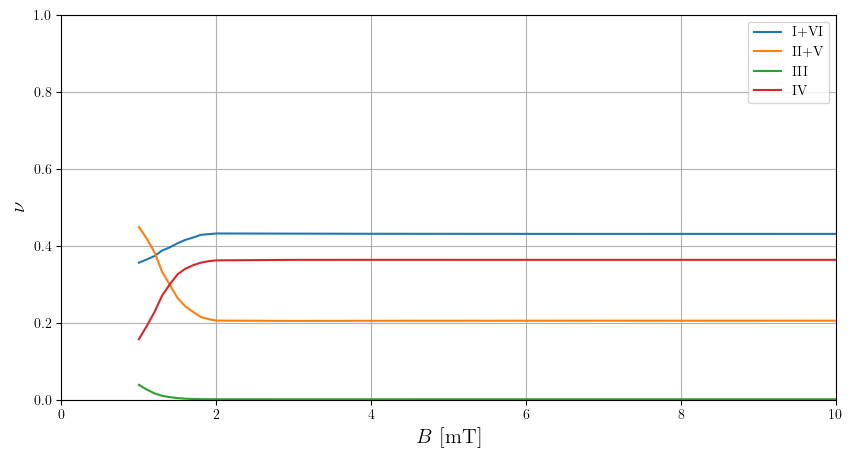

In [200]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(fields,counts.I+counts.VI, label='I+VI')
ax.plot(fields,counts.II+counts.V, label='II+V')
ax.plot(fields,counts.III, label='III')
ax.plot(fields,counts.IV, label='IV')
ax.legend()

ax.set_xlabel('$B$ [mT]',fontsize=15)
ax.set_ylabel('$\\nu$',fontsize=15)
ax.set_ylim(0,1)
ax.set_xlim(0,10)

ax.grid()
ax.legend()
plt.show()

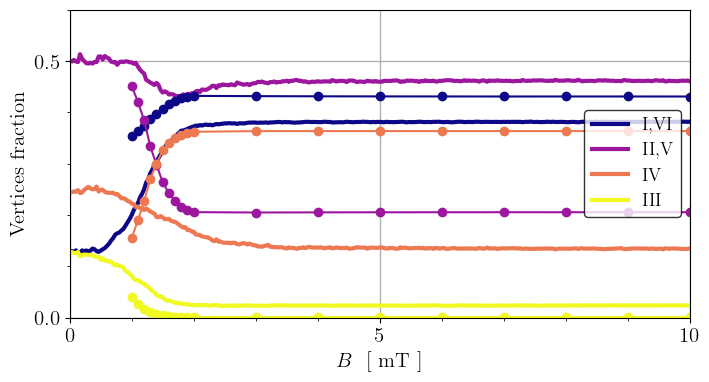

In [179]:
fig, ax = plt.subplots(figsize=(8,4))

types = ['I,VI','II,V','IV','III']

for i in range(4):
        ax.plot(field, gbig[i], color = colors[i], linewidth=3, label = types[i])
        #ax.plot(field[::10], gsmall[i][::10], 'D', color = colors[i], markersize=5)
        
ax.plot(fields,counts.I+counts.VI,'-o', color = colors[0])
ax.plot(fields,counts.II+counts.V,'-o', color = colors[1])
ax.plot(fields,counts.IV,'-o', color = colors[2])
ax.plot(fields,counts.III,'-o', color = colors[3])

ax.legend(fontsize=13,edgecolor='black')

ax.set_xlim(0,10)
ax.set_ylim(0,0.6)

ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.xaxis.set_minor_formatter(plt.NullFormatter())


ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_minor_formatter(plt.NullFormatter())


ax.set_ylabel('Vertices fraction', fontsize=15)
ax.set_xlabel("$B$ \\,\\,[ mT ] ", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(True, which='major', linewidth = 1)
ax.minorticks_on()

plt.show()
 

# Super slow shit

In [69]:
datapath = os.path.join(DRIVE_MOUNT,PROJECT,'sims_superslow_preliminary')
vrt = ice.vrt_dict(datapath)

In [ ]:
new_vrt = {}
for r,df in vrt.items():
    df = df.reset_index()
    new_frames = (df['frame']* params['dt'].to(ureg.s).magnitude).to_list()
    df['frame'] = new_frames
    df = df.set_index(['frame','vertex'])
    new_vrt[r] = df

In [72]:
counts = ice.vrt_counts(new_vrt)

In [84]:
cav = ice.unstack(pd.concat(
[stuff.fraction for stuff in counts.values()],axis=1
).dropna().mean(axis=1))

field = 1/3000 * cav.index.get_level_values('frame').unique().to_numpy()

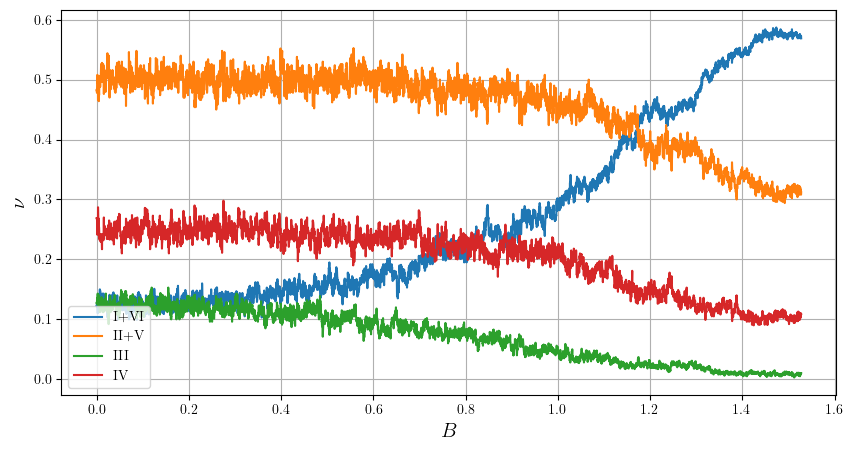

In [93]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(field, cav.I + cav.VI,label='I+VI')
ax.plot(field, cav.II + cav.V,label='II+V')
ax.plot(field, cav.III,label='III')
ax.plot(field,cav.IV,label='IV')

ax.grid()
ax.set_xlabel('$B$',fontsize=15)
ax.set_ylabel('$\\nu$',fontsize=15)
ax.legend()
plt.show()

In [96]:
cav.to_csv(os.path.join(datapath,'counts.csv'))